In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import shutil

In [2]:
# Remove old plots and create directory for new ones
dir_path = "/Users/giorgioclauser/Documents/covid_plts/italia"
shutil.rmtree(dir_path)
os.mkdir(dir_path)

In [3]:
# Set working directory to home
os.chdir("/Users/giorgioclauser/Projects/covid_ita/")

In [4]:
# Import national data
df_ita = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")

In [5]:
# Feature engineering
df_ita["prcn_tamponi_positivi_overall"] = df_ita["totale_casi"]/df_ita["tamponi"]
df_ita["prcn_tamponi_positivi_daily"] = df_ita["variazione_totale_positivi"]/(df_ita["tamponi"] - df_ita["tamponi"].shift(1))
df_ita['reference_day'] = df_ita.data.apply(lambda x: x[5:10])
df_ita['nuovi_positivi'] = df_ita['totale_positivi'] - df_ita["totale_positivi"].shift(1)
df_ita["growth_rate"] = df_ita["totale_positivi"]/df_ita["totale_positivi"].shift(1)

In [6]:
df_ita.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en,prcn_tamponi_positivi_overall,prcn_tamponi_positivi_daily,reference_day,growth_rate
107,2020-06-10T17:00:00,ITA,4320,249,4569,27141,31710,-1162,-1162.0,169939,34114,235763,4381349,2713554.0,NaN,NaN,0.053811,-0.018533,06-10,0.964651
108,2020-06-11T17:00:00,ITA,4131,236,4367,26270,30637,-1073,-1073.0,171338,34167,236142,4443821,2746545.0,NaN,NaN,0.053139,-0.017176,06-11,0.966162
109,2020-06-12T17:00:00,ITA,3893,227,4120,24877,28997,-1640,-1640.0,173085,34223,236305,4514441,2784196.0,dc-IT-0045;dc-IT-0047,dc-EN-0045;dc-EN-0047,0.052344,-0.023223,06-12,0.946470
110,2020-06-13T17:00:00,ITA,3747,220,3967,23518,27485,-1512,-1512.0,174865,34301,236651,4564191,2817076.0,dc-IT-0049,dc-EN-0049,0.051849,-0.030392,06-13,0.947857
111,2020-06-14T17:00:00,ITA,3594,209,3803,22471,26274,-1211,-1211.0,176370,34345,236989,4620718,2846621.0,NaN,NaN,0.051288,-0.021423,06-14,0.955940


In [7]:
# Giorni con decreti:
day_decreti = ['03-04', '03-08', '03-09', '03-11', '03-22']
fase2 = ['05-04']
fase3 = ['06-03']

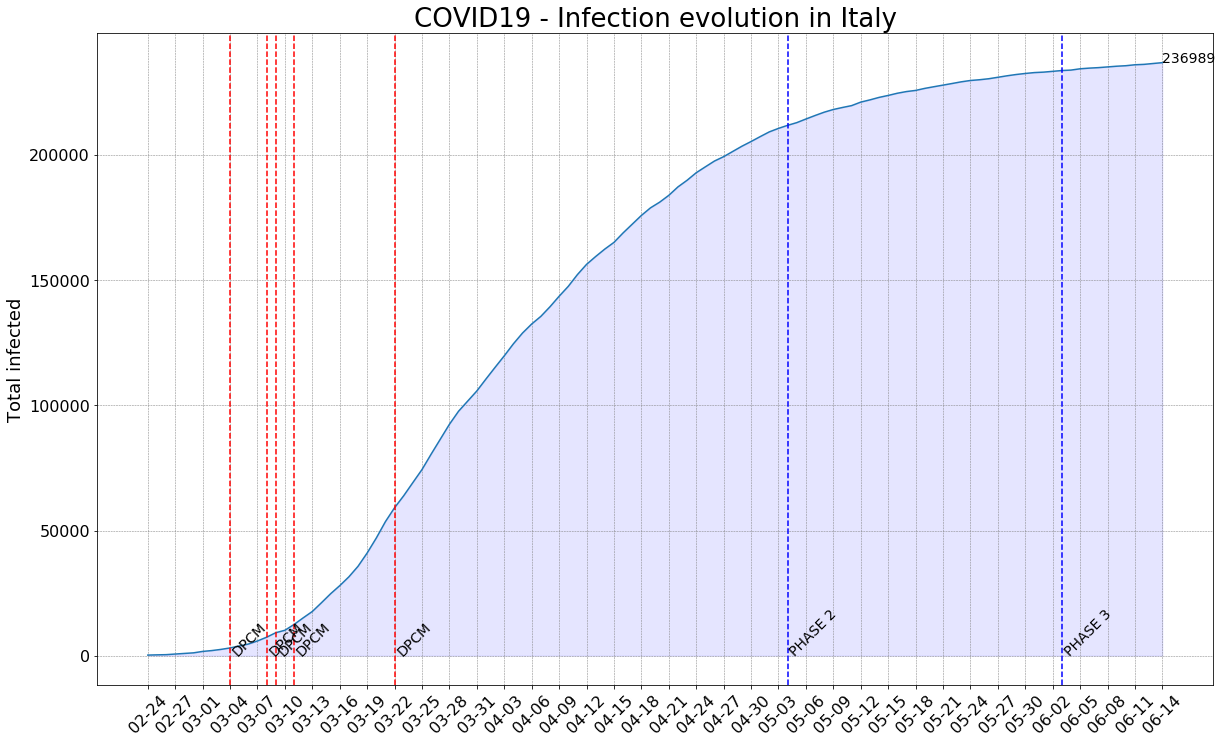

In [8]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_casi",
                  data=df_ita)
plt.fill_between(x='reference_day', y1='totale_casi', y2=0 ,data=df_ita, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Total infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.totale_casi[len(df_ita)-1],
         df_ita.totale_casi[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::3])
plt.savefig(f"{dir_path}/infection_evolution_ita.png")
plt.show()

In [9]:
def get_trend(series):
    from pandas import datetime
    from sklearn.linear_model import LinearRegression
    from matplotlib import pyplot
    import numpy
     
    def parser(x):
        return datetime.strptime('190'+x, '%Y-%m')
     
    series = series.dropna()
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = numpy.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    return trend

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


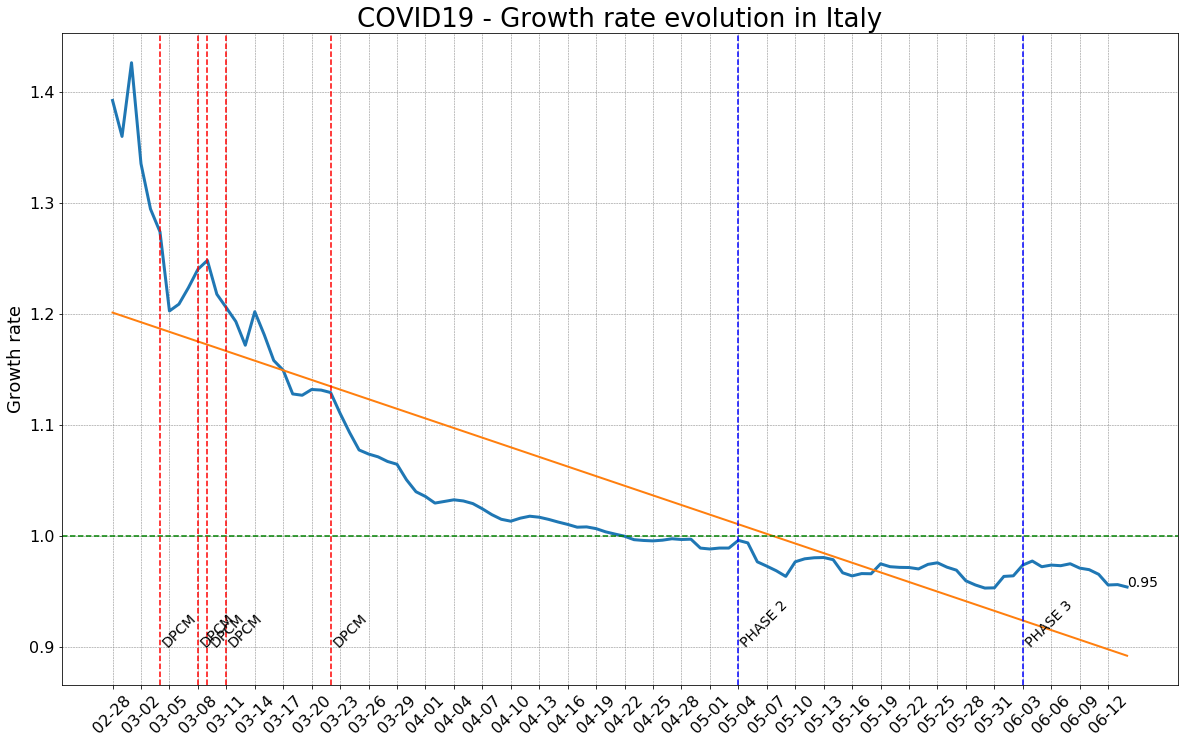

In [10]:
# Generate plot
df_gr = df_ita[["reference_day", "growth_rate"]].dropna().copy()
df_gr["growth_rate"] = df_gr.growth_rate.rolling(window=4).mean()
df_gr.dropna(inplace=True)
df_gr["trend"] = get_trend(df_gr["growth_rate"])
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="growth_rate",
                  data=df_gr, lw=3)
ax = sns.lineplot(x="reference_day", y="trend",
                  data=df_gr, lw=2)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Growth rate', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Growth rate evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
#plt.ylim(bottom=0, top=1.6)
ax.axhline(1, ls='--', color='green', lw=1.5)
plt.text(df_gr.reference_day[len(df_ita)-1], 
         df_gr.growth_rate[len(df_ita)-1],
         round(df_gr.growth_rate[len(df_ita)-1],2), fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .9,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .9,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .9,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::3])
plt.savefig(f"{dir_path}/growth_rate_ita.png")
plt.show()

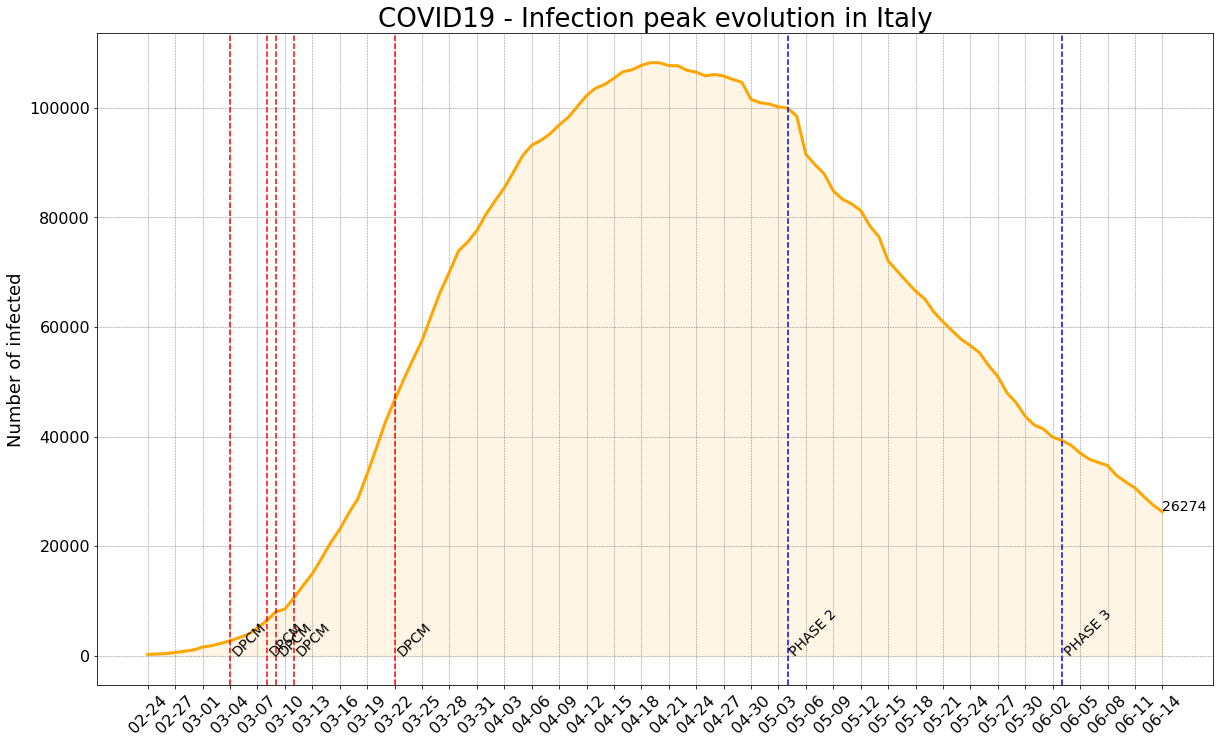

In [11]:
# What does the peak look like?
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_positivi",
                  data=df_ita, lw=3, color='orange')
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.fill_between(x='reference_day', y1='totale_positivi', y2=0 ,data=df_ita, color='orange', alpha=.1)
plt.ylabel('Number of infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection peak evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.totale_positivi[len(df_ita)-1]+144,
         df_ita.totale_positivi[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .5,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::3])
plt.savefig(f"{dir_path}/peak_evolution_ita.png")
plt.show()

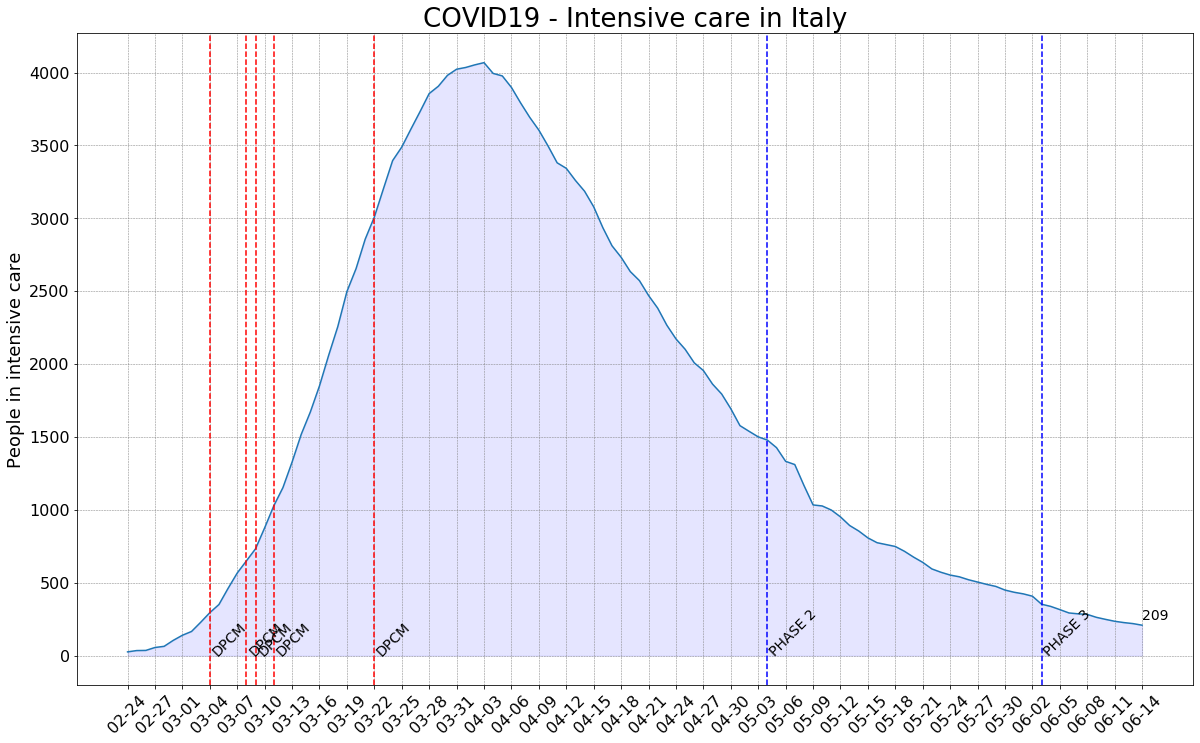

In [12]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="terapia_intensiva",
                  data=df_ita)
plt.fill_between(x='reference_day', y1='terapia_intensiva', y2=0 ,data=df_ita, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('People in intensive care', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Intensive care in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.terapia_intensiva[len(df_ita)-1]+34,
         df_ita.terapia_intensiva[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::3])
plt.savefig(f"{dir_path}/intensive_care_ita.png")
plt.show()